# Demo: 2D Polygon Sampling and PCA Analysis

This notebook demonstrates:
1. Loading 2D polygon data
2. Sampling surface points and computing normals
3. PCA decomposition and visualization
4. Segment scaling and subdivision
5. Segment analysis with SDF profiles

In [10]:
from neural_spline.utils import load_mesh_data
from neural_spline.spline import sample_surface_pointcloud, get_knots_and_sdf2, scale_segments, subdivide_segments
from neural_spline.geometry import constrained_recursive_pca
import torch
import matplotlib.pyplot as plt
import numpy as np

In [11]:
# Load 2D polygon data
data = load_mesh_data('simple')
print(f"Data type: {data['type']}")
print(f"Vertices shape: {data['vertices'].shape}")
print(f"Edges shape: {data['edges'].shape}")

  Generating simple convex polygons...
  Mesh vertices: 32, faces: 60
  Polygon vertices: 16, edges: 16
Data type: 2d
Vertices shape: torch.Size([16, 2])
Edges shape: torch.Size([16, 2])


In [ ]:
# Sample surface points and normals
num_samples = 100
points, normals = sample_surface_pointcloud(data, num_samples)
print(f"Sampled points shape: {points.shape}")
print(f"Normals shape: {normals.shape}")

Sampled points shape: torch.Size([2000, 2])
Normals shape: torch.Size([2000, 2])


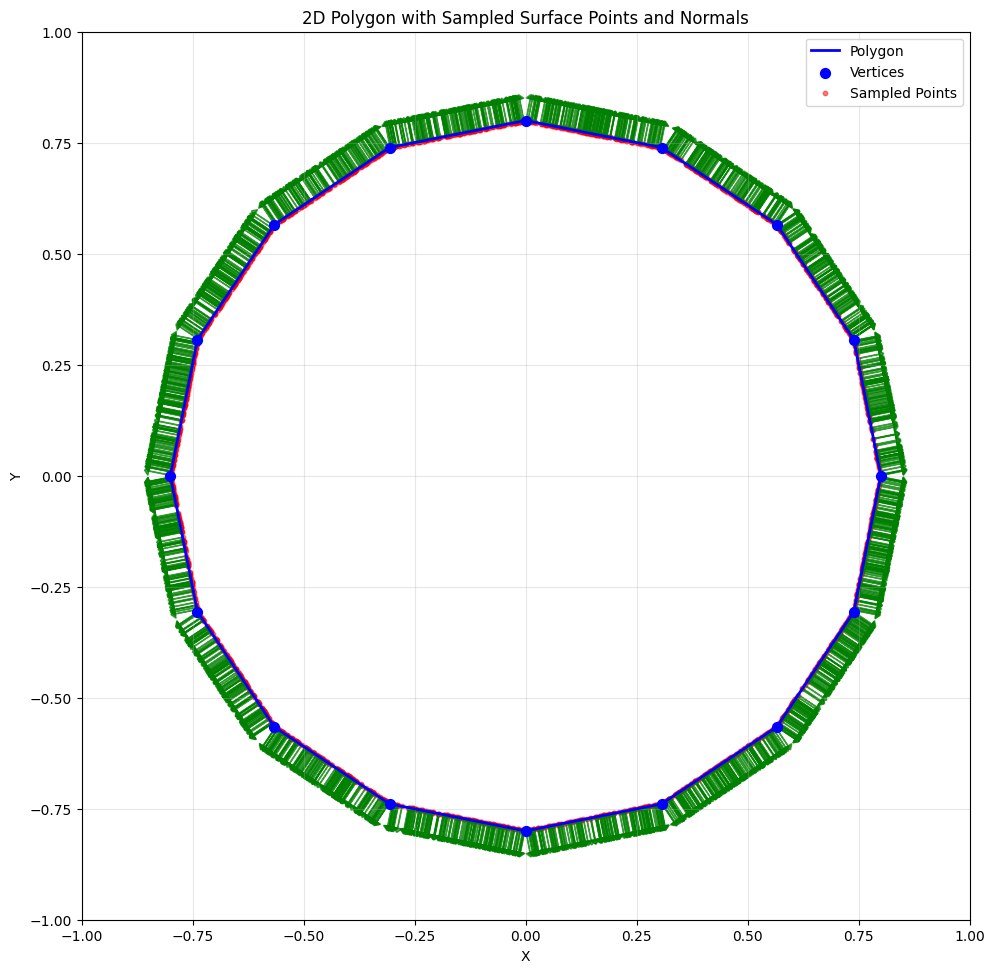

In [13]:
# Plot polygon with sampled points and normals
fig, ax = plt.subplots(figsize=(10, 10))

# Plot polygon edges
vertices = data['vertices'].cpu().numpy()
edges = data['edges'].cpu().numpy()

for edge in edges:
    v0 = vertices[edge[0]]
    v1 = vertices[edge[1]]
    ax.plot([v0[0], v1[0]], [v0[1], v1[1]], 'b-', linewidth=2, label='Polygon' if edge[0] == 0 else '')

# Plot vertices
ax.scatter(vertices[:, 0], vertices[:, 1], c='blue', s=50, zorder=5, label='Vertices')

# Plot sampled points
points_np = points.cpu().numpy()
normals_np = normals.cpu().numpy()
ax.scatter(points_np[:, 0], points_np[:, 1], c='red', s=10, alpha=0.5, label='Sampled Points')

# Plot normals (subsample for visibility)
step = 1
normal_scale = 0.05
for i in range(0, len(points), step):
    p = points_np[i]
    n = normals_np[i]
    ax.arrow(p[0], p[1], n[0]*normal_scale, n[1]*normal_scale, 
             head_width=0.02, head_length=0.01, fc='green', ec='green', alpha=0.7)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('2D Polygon with Sampled Surface Points and Normals')
ax.set_aspect('equal')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# Perform constrained recursive PCA
from neural_spline.geometry import flatten_pca_tree

node = constrained_recursive_pca(
    points=data['vertices'],
    max_depth=4,
    min_points=2
)
components = flatten_pca_tree(node)
print(f"Number of PCA components: {len(components)}")

Number of PCA components: 10


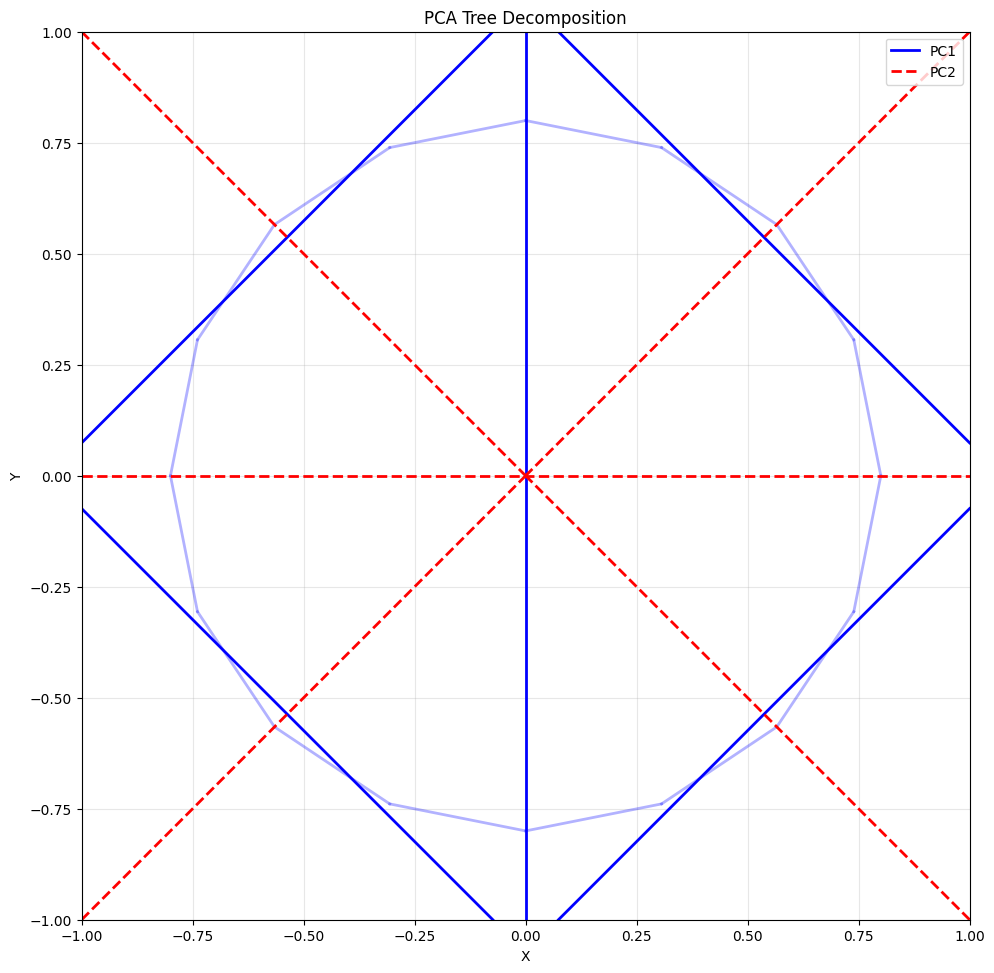

In [18]:
# Plot PCA tree structure with polygon
fig, ax = plt.subplots(figsize=(10, 10))

# Plot polygon
for edge in edges:
    v0 = vertices[edge[0]]
    v1 = vertices[edge[1]]
    ax.plot([v0[0], v1[0]], [v0[1], v1[1]], 'b-', linewidth=2, alpha=0.3)

# Plot PCA components colored by component index
pc1_plotted = False
pc2_plotted = False

for component in components:
    start = component.start.cpu().numpy()
    end = component.end.cpu().numpy()
    
    # component_idx: 0 = PC1, 1 = PC2
    if component.component_idx == 0:
        color = 'blue'
        linestyle = '-'
        label = 'PC1' if not pc1_plotted else ''
        pc1_plotted = True
    else:
        color = 'red'
        linestyle = '--'
        label = 'PC2' if not pc2_plotted else ''
        pc2_plotted = True
    
    ax.plot([start[0], end[0]], [start[1], end[1]], 
            color=color, linestyle=linestyle, linewidth=2, label=label)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('PCA Tree Decomposition')
ax.set_aspect('equal')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# Scale and subdivide segments
start_points = torch.stack([c.start for c in components])
end_points = torch.stack([c.end for c in components])

# First scale to get L, then subdivide
start_points_scaled, end_points_scaled, L = scale_segments(start_points, end_points)
start_points_sub, end_points_sub, t_start, t_end, mapping_idx = subdivide_segments(
    start_points_scaled, end_points_scaled, L
)

print(f"Original segments: {len(components)}")
print(f"Subdivided segments: {len(start_points_sub)}")
print(f"Base length L: {L:.4f}")

Original segments: 10
Subdivided segments: 12
Base length L: 1.3096


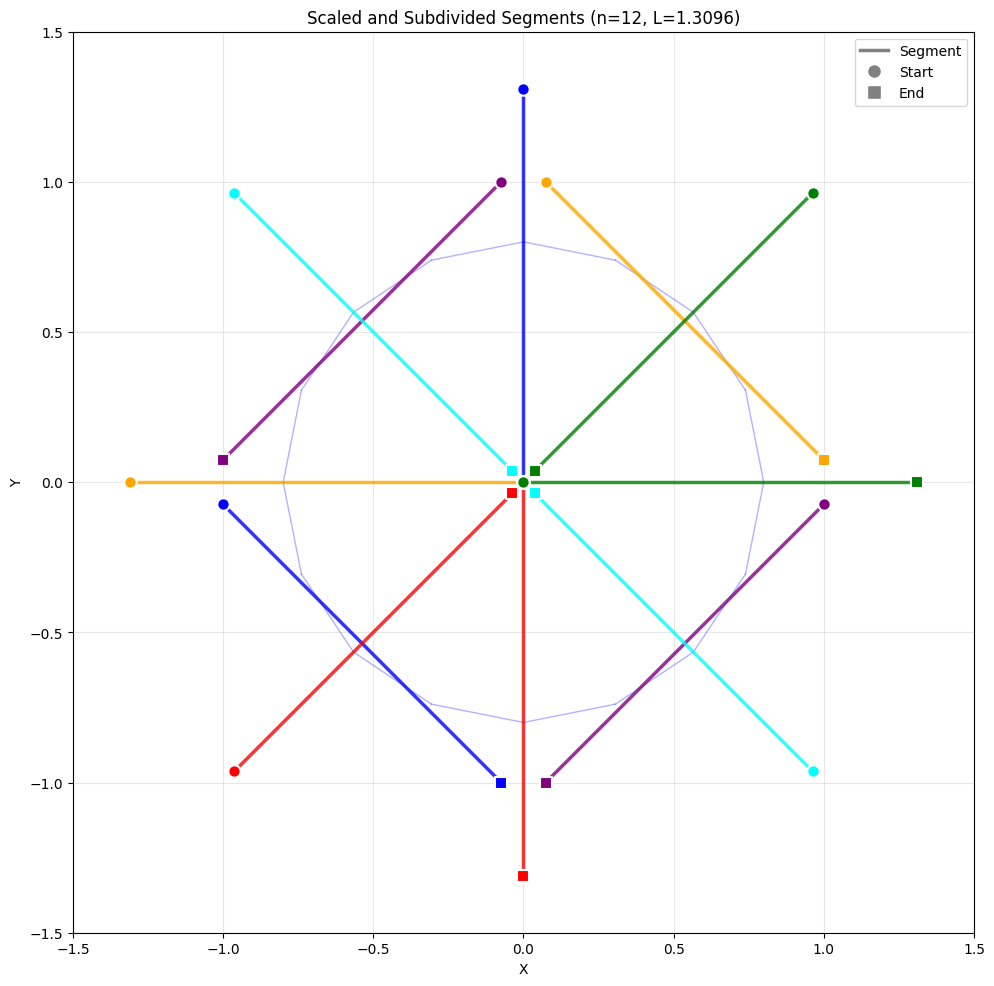

In [20]:
# Plot subdivided segments
fig, ax = plt.subplots(figsize=(10, 10))

# Plot polygon
for edge in edges:
    v0 = vertices[edge[0]]
    v1 = vertices[edge[1]]
    ax.plot([v0[0], v1[0]], [v0[1], v1[1]], 'b-', linewidth=1, alpha=0.3, label='Polygon' if edge[0] == 0 else '')

# Plot subdivided segments with start/end markers
n_segments = len(start_points_sub)
pc_colors = ['blue', 'red', 'orange', 'green', 'purple', 'cyan']

for i in range(n_segments):
    start = start_points_sub[i].cpu().numpy()
    end = end_points_sub[i].cpu().numpy()
    
    # Use alternating colors for visual distinction
    color = pc_colors[i % len(pc_colors)]
    
    # Plot line segment
    ax.plot([start[0], end[0]], [start[1], end[1]], 
            color=color, linewidth=2.5, alpha=0.8)
    
    # Plot start point (circle)
    ax.scatter(start[0], start[1], c=color, marker='o', s=80, 
               edgecolors='white', linewidths=1.5, zorder=10)
    
    # Plot end point (square)
    ax.scatter(end[0], end[1], c=color, marker='s', s=80, 
               edgecolors='white', linewidths=1.5, zorder=10)

# Add custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=2.5, label='Segment'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Start'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=10, label='End')
]
ax.legend(handles=legend_elements)

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Scaled and Subdivided Segments (n={n_segments}, L={L:.4f})')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Call get_knots_and_sdf2 with all required parameters
sdf_vals, sdf_grads, knots, nconf, sconf, sign_uncertain = get_knots_and_sdf2(
    start_points=start_points_sub,
    end_points=end_points_sub,
    sample_points=points,
    sample_normals=normals,
    batch_size=1,
    n_samples_per_segment=128,
    n_selected_samples=32,
    knn_k=10,
)

def plot_segment_analysis(seg_idx):
    """
    Visualize a specific segment with its SDF profile.
    
    Args:
        seg_idx: Index of segment to analyze
        num_knots: Number of sample points along segment
    """
    start = start_points_sub[seg_idx]
    end = end_points_sub[seg_idx]
    
    # Get results for this specific segment
    knots_t = knots[seg_idx]  # Parameterization values (0 to 1)
    sdf = sdf_vals[seg_idx]   # SDF values
    normals = sdf_grads[seg_idx]  # Normals
    
    # Convert to numpy
    knots_t_np = knots_t.cpu().numpy()
    sdf_np = sdf.cpu().numpy()
    normals_np = normals.cpu().numpy()
    start_np = start.cpu().numpy()
    end_np = end.cpu().numpy()
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Left: Segment on polygon
    ax = axes[0]
    # Plot polygon
    vertices_np = data['vertices'].cpu().numpy()
    edges_np = data['edges'].cpu().numpy()
    for edge in edges_np:
        v0 = vertices_np[edge[0]]
        v1 = vertices_np[edge[1]]
        ax.plot([v0[0], v1[0]], [v0[1], v1[1]], 'b-', linewidth=2, alpha=0.5)
    # Plot selected segment
    ax.plot([start_np[0], end_np[0]], [start_np[1], end_np[1]], 
            'purple', linewidth=2.5, label='Selected segment')
    ax.scatter(start_np[0], start_np[1], c='blue', marker='o', s=80, 
               edgecolors='white', linewidths=1.5, zorder=10, label='Start')
    ax.scatter(end_np[0], end_np[1], c='blue', marker='s', s=80, 
               edgecolors='white', linewidths=1.5, zorder=10, label='End')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Segment {seg_idx} (depth=0, PC1)')
    ax.set_aspect('equal')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Middle: SDF profile
    ax = axes[1]
    ax.plot(knots_t_np, sdf_np, 'b-', linewidth=2, marker='o', markersize=6)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.set_xlabel('Knot position (t)')
    ax.set_ylabel('SDF value')
    ax.set_title('SDF along segment')
    ax.grid(True, alpha=0.3)
    
    # Right: Normal components
    ax = axes[2]
    ax.plot(knots_t_np, normals_np[:, 0], 'r-o', linewidth=2, markersize=6, label='Normal X')
    ax.plot(knots_t_np, normals_np[:, 1], 'b-s', linewidth=2, markersize=6, label='Normal Y')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.set_xlabel('Knot position (t)')
    ax.set_ylabel('Normal component')
    ax.set_title('Normals along segment')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print(f"Total segments available: {len(start_points_sub)}")
print("Use: plot_segment_analysis(seg_idx) to visualize a specific segment")

Computing SDF: 100%|██████████| 12/12 [00:00<00:00, 1355.08it/s]

Total segments available: 12
Use: plot_segment_analysis(seg_idx) to visualize a specific segment


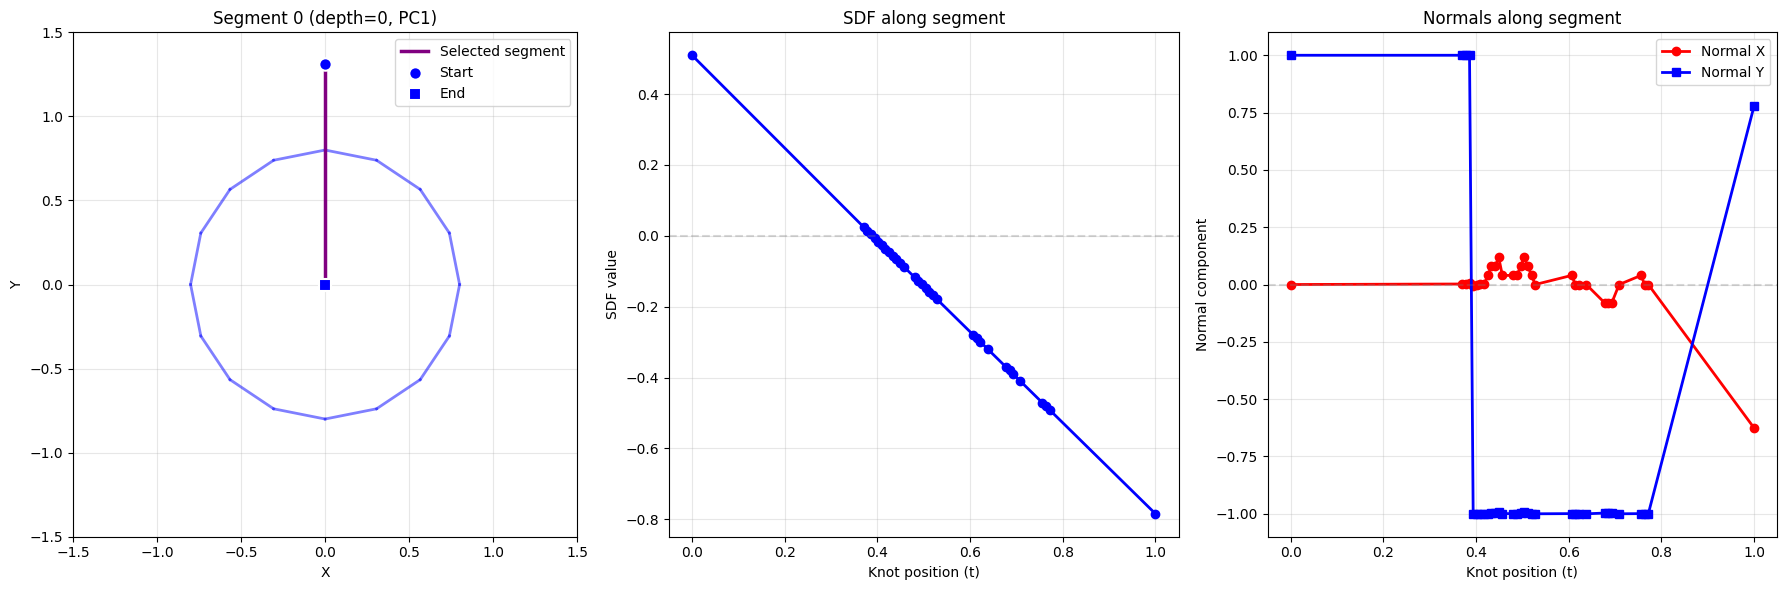

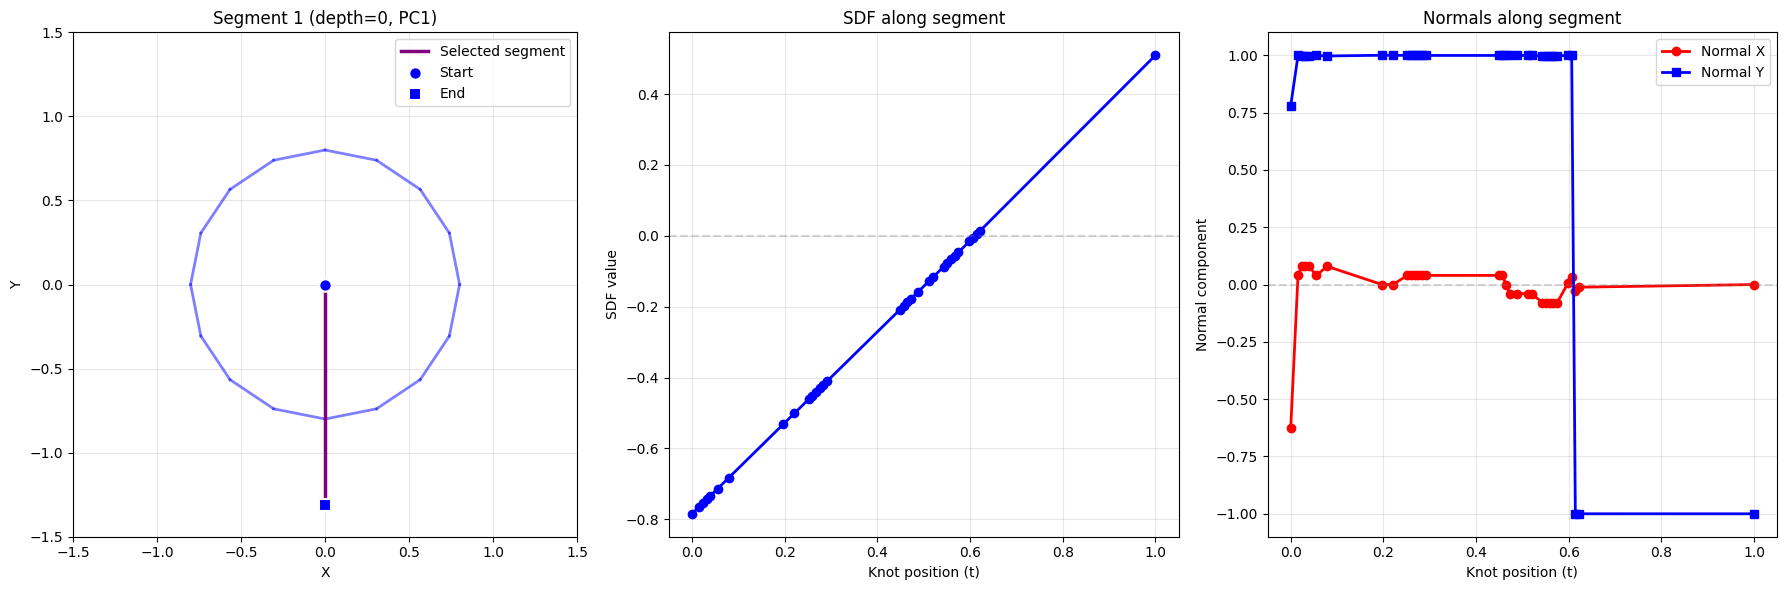

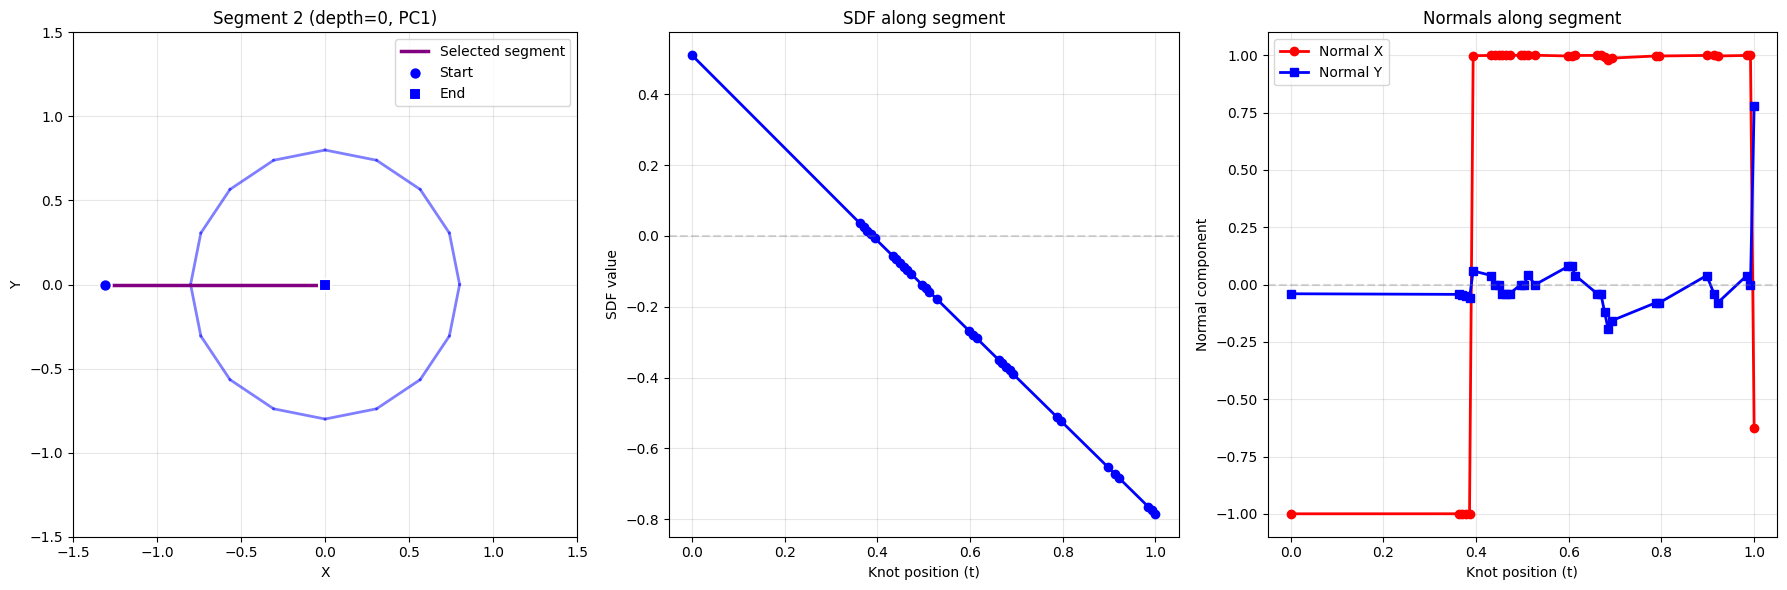

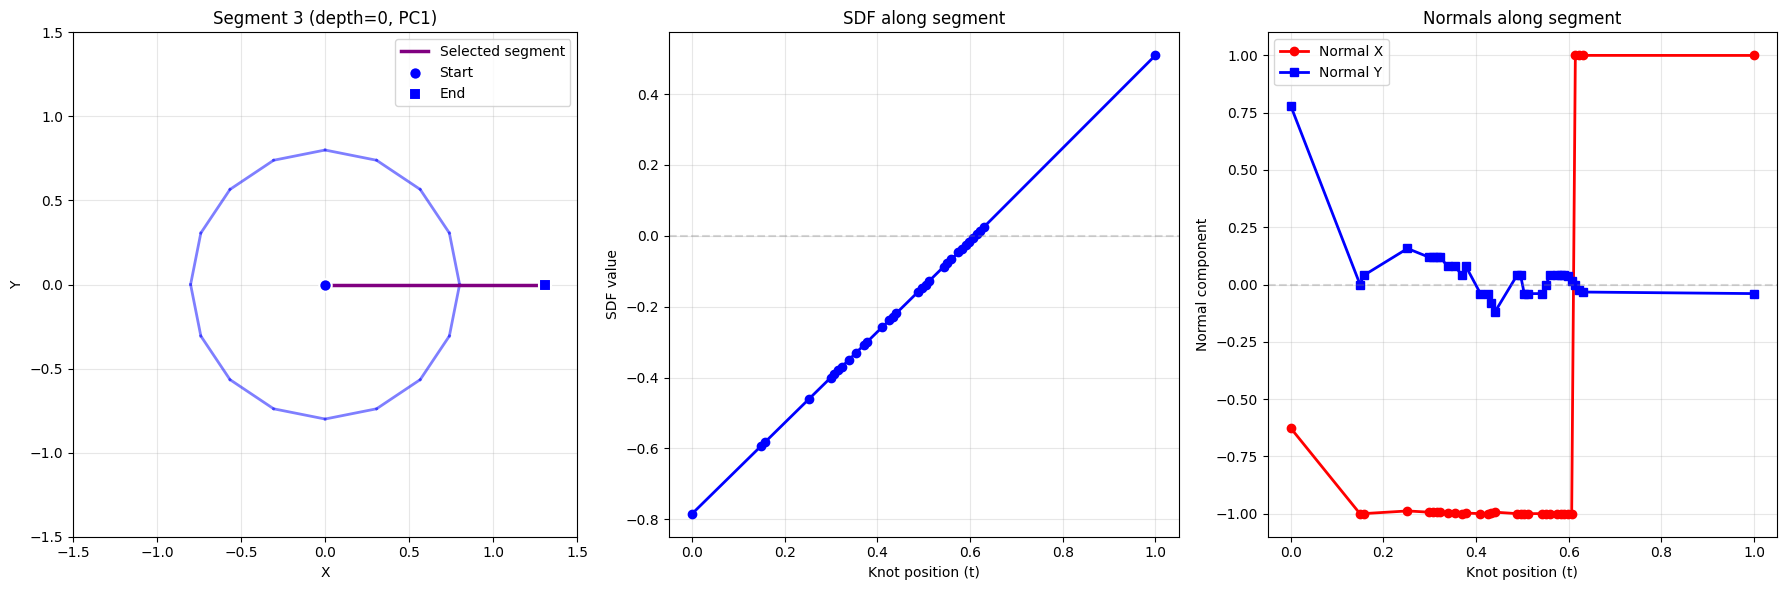

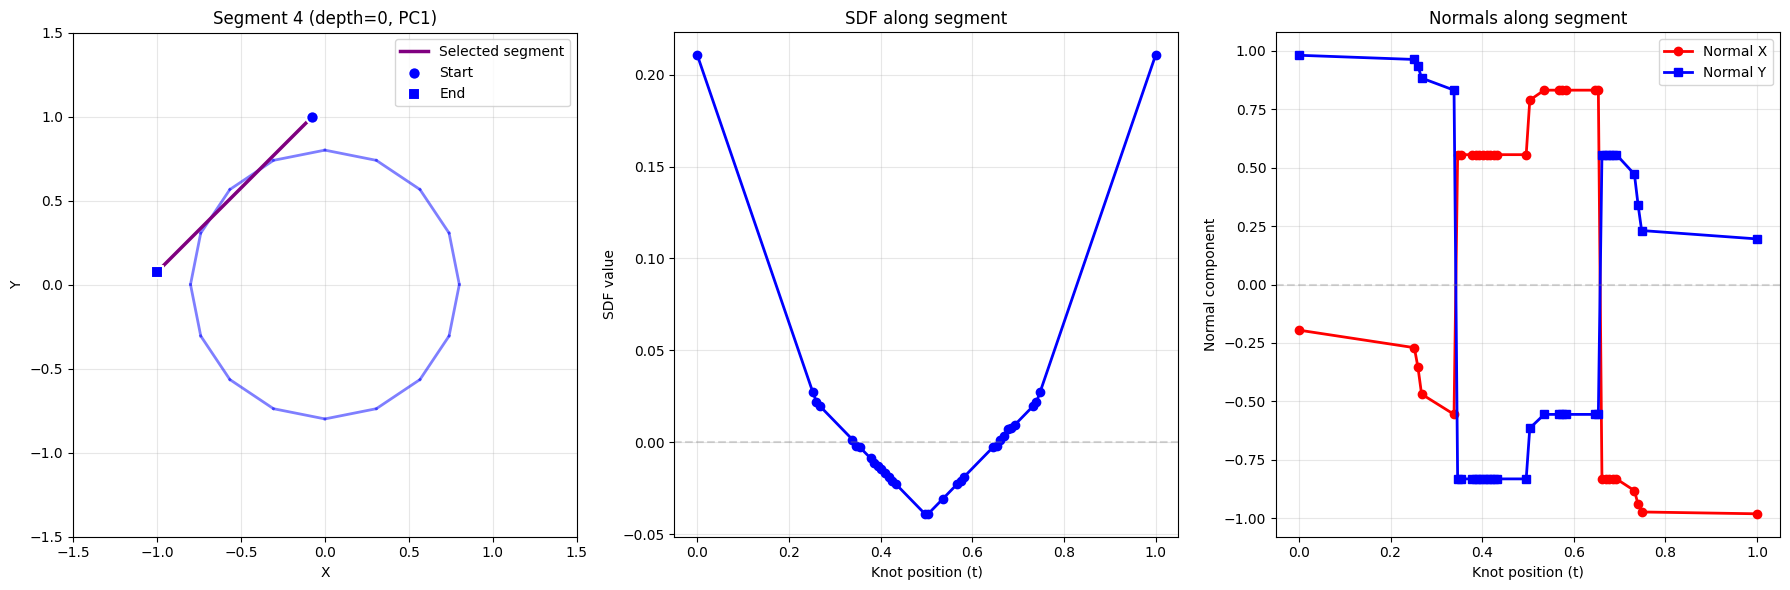

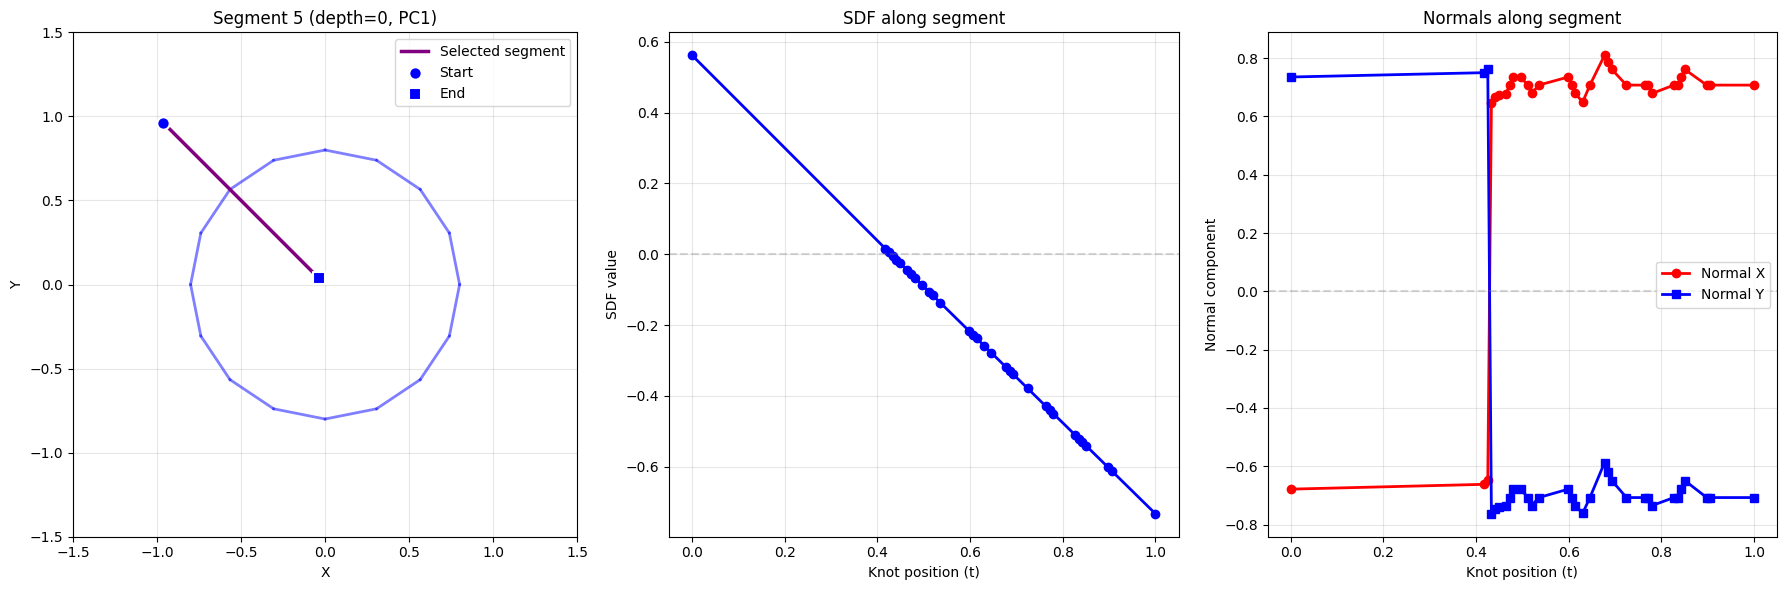

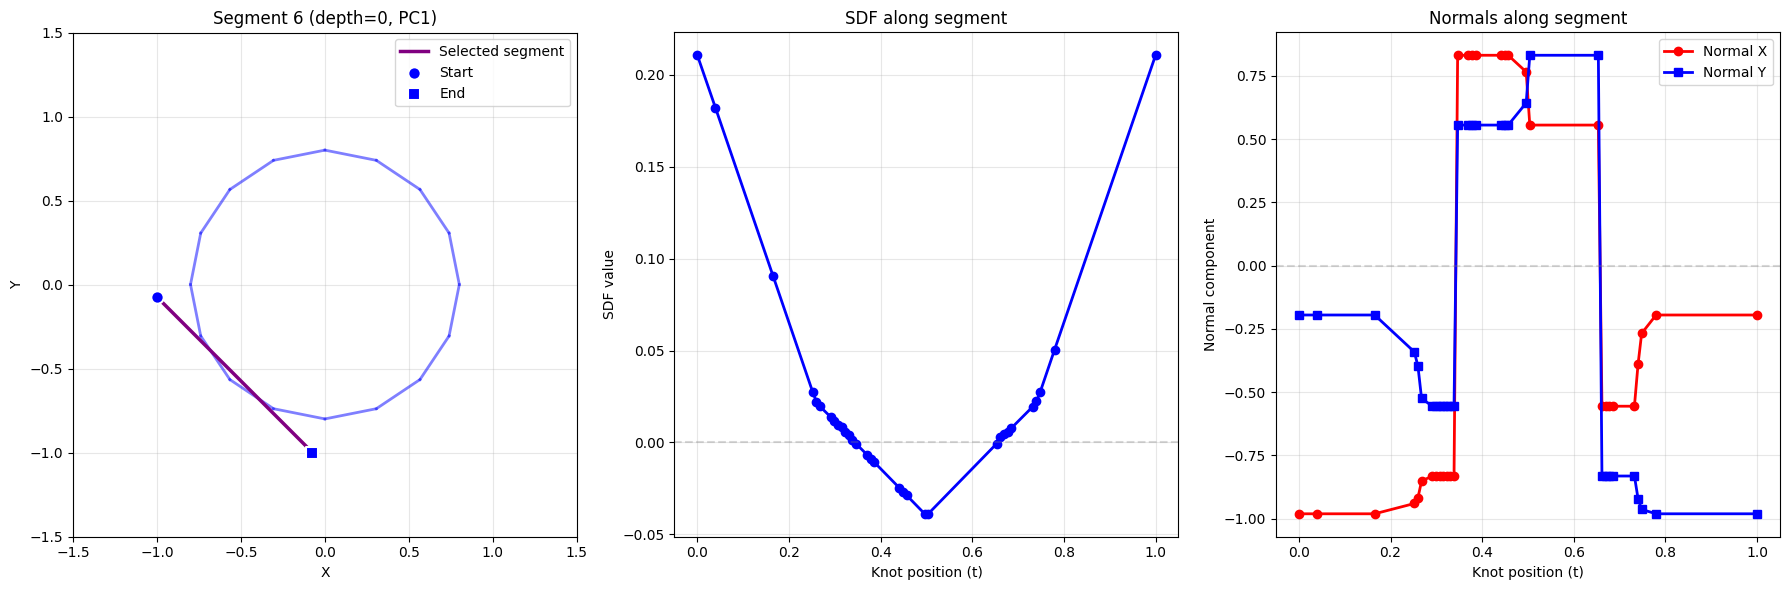

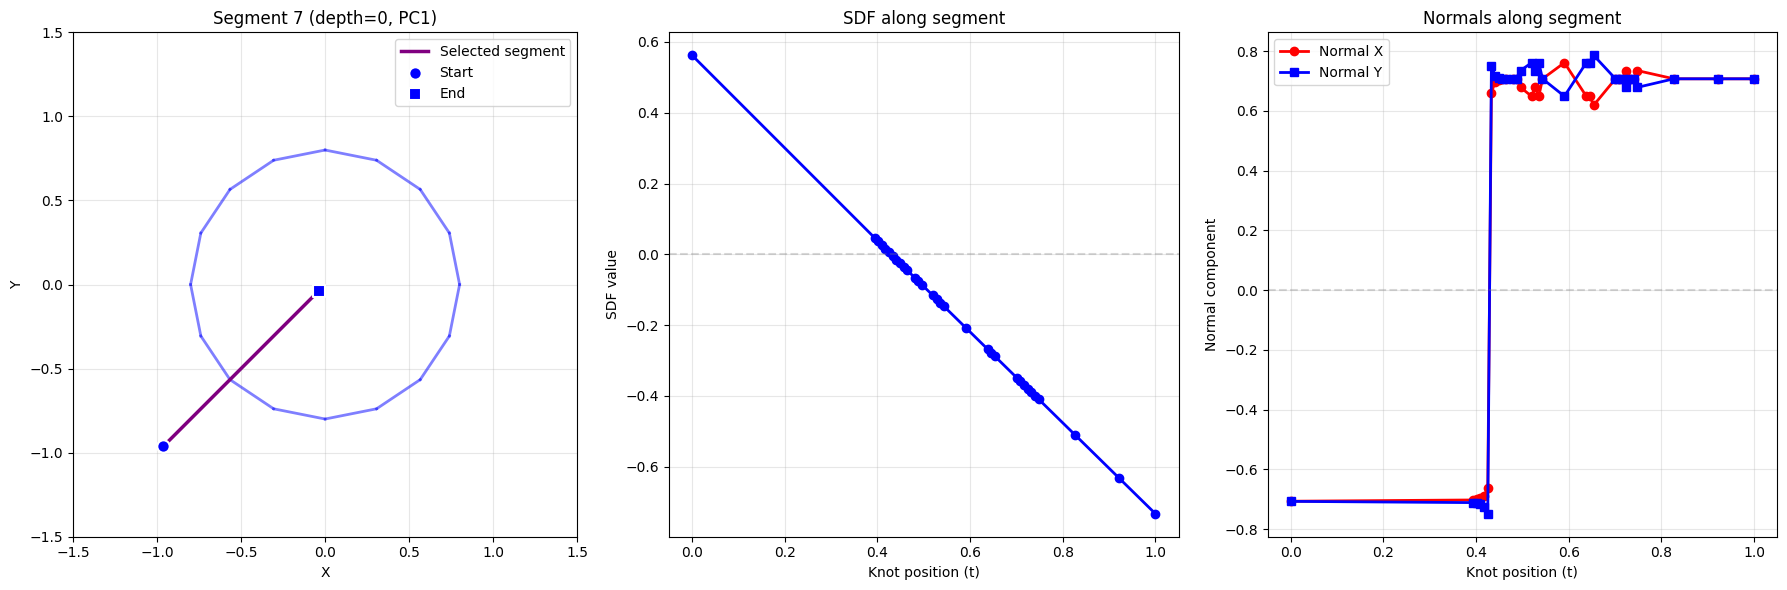

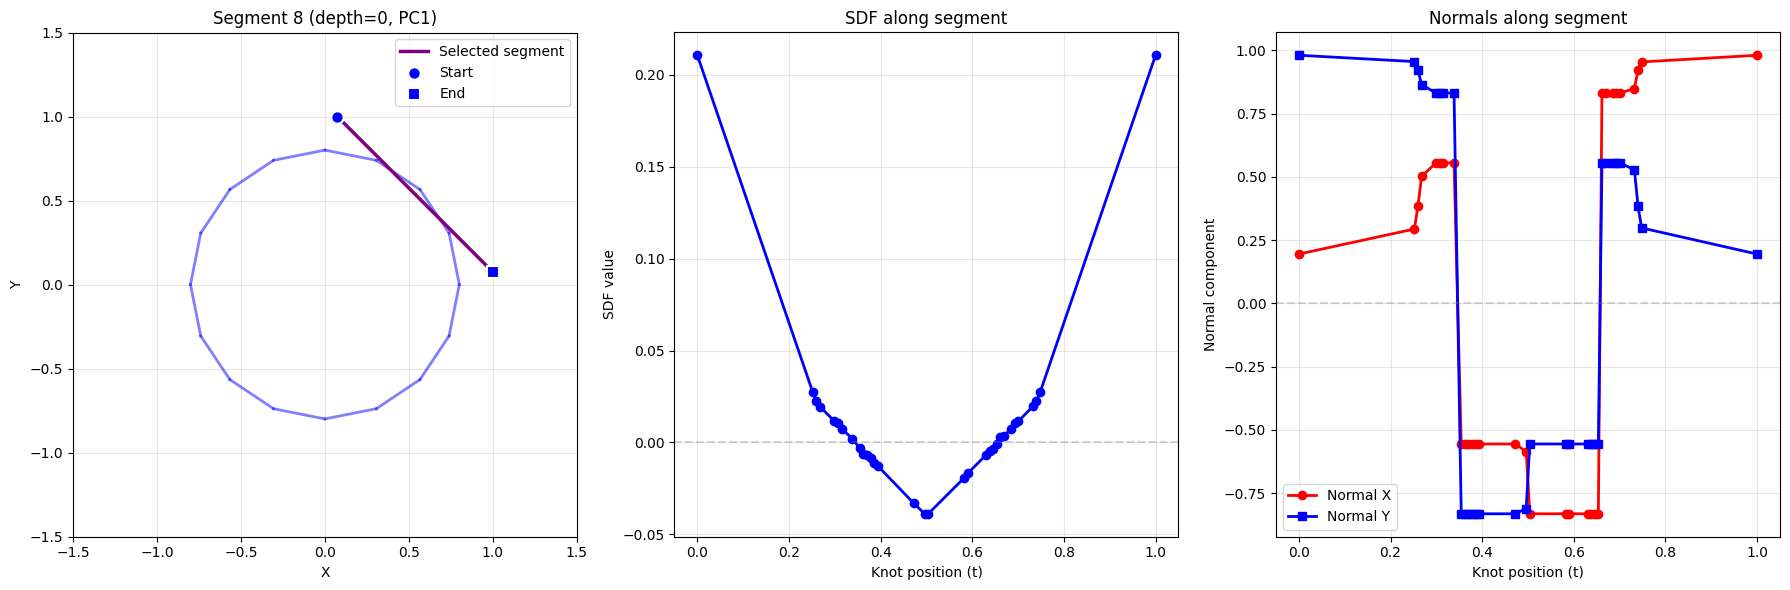

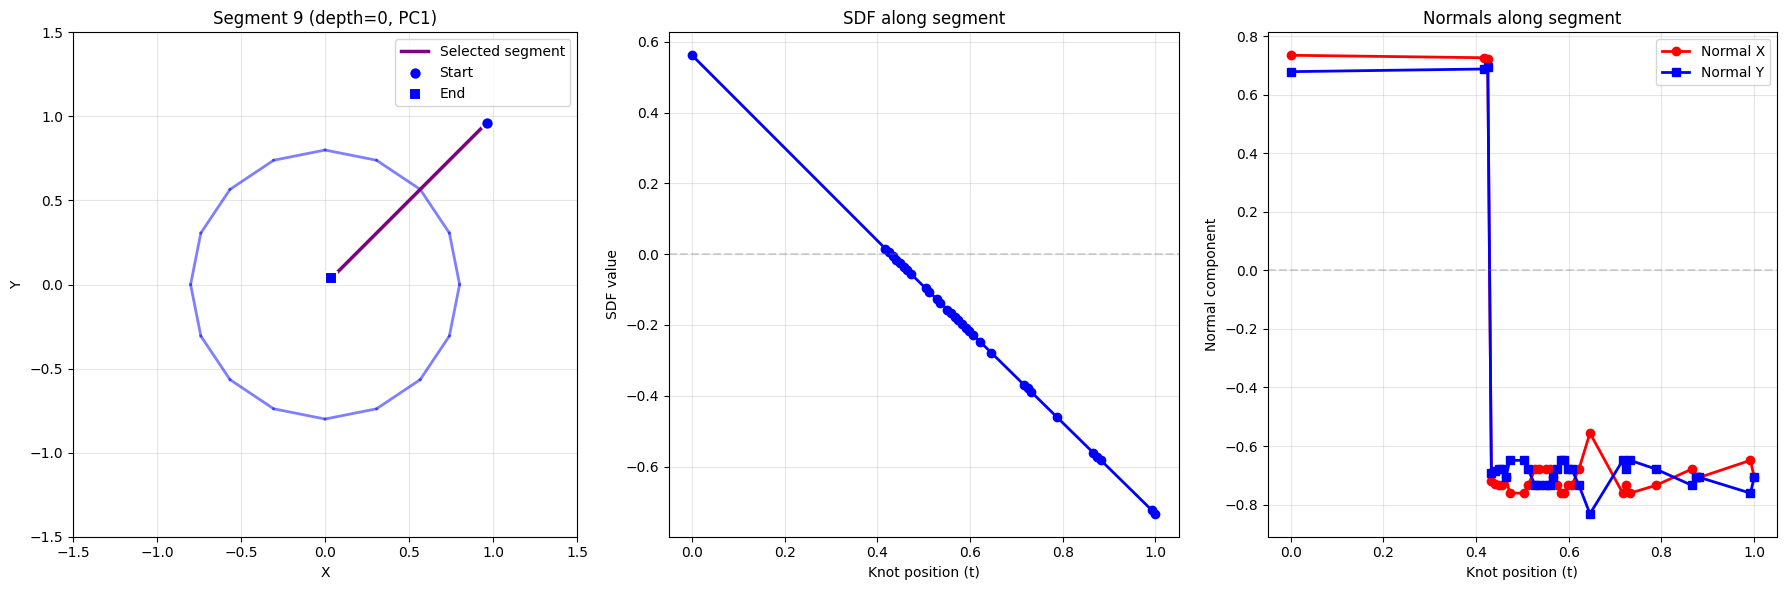

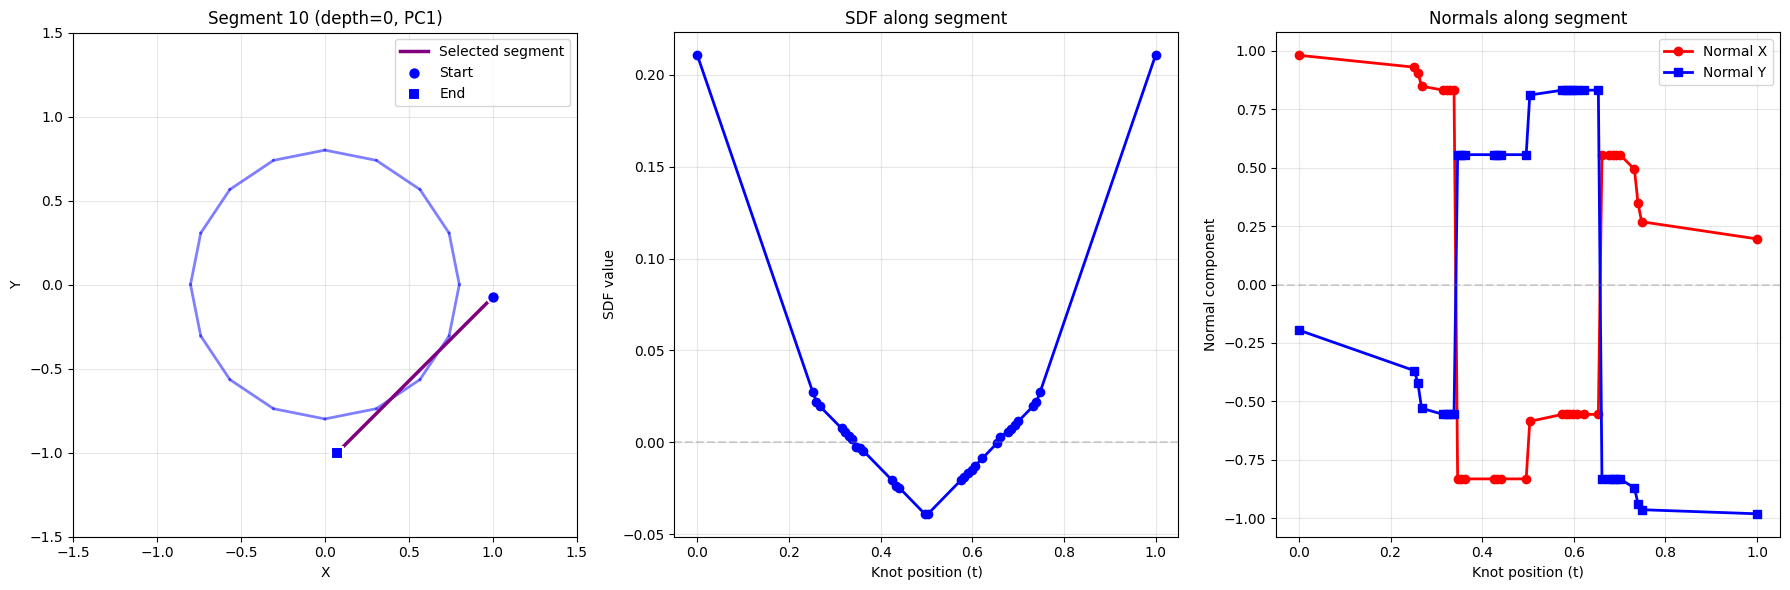

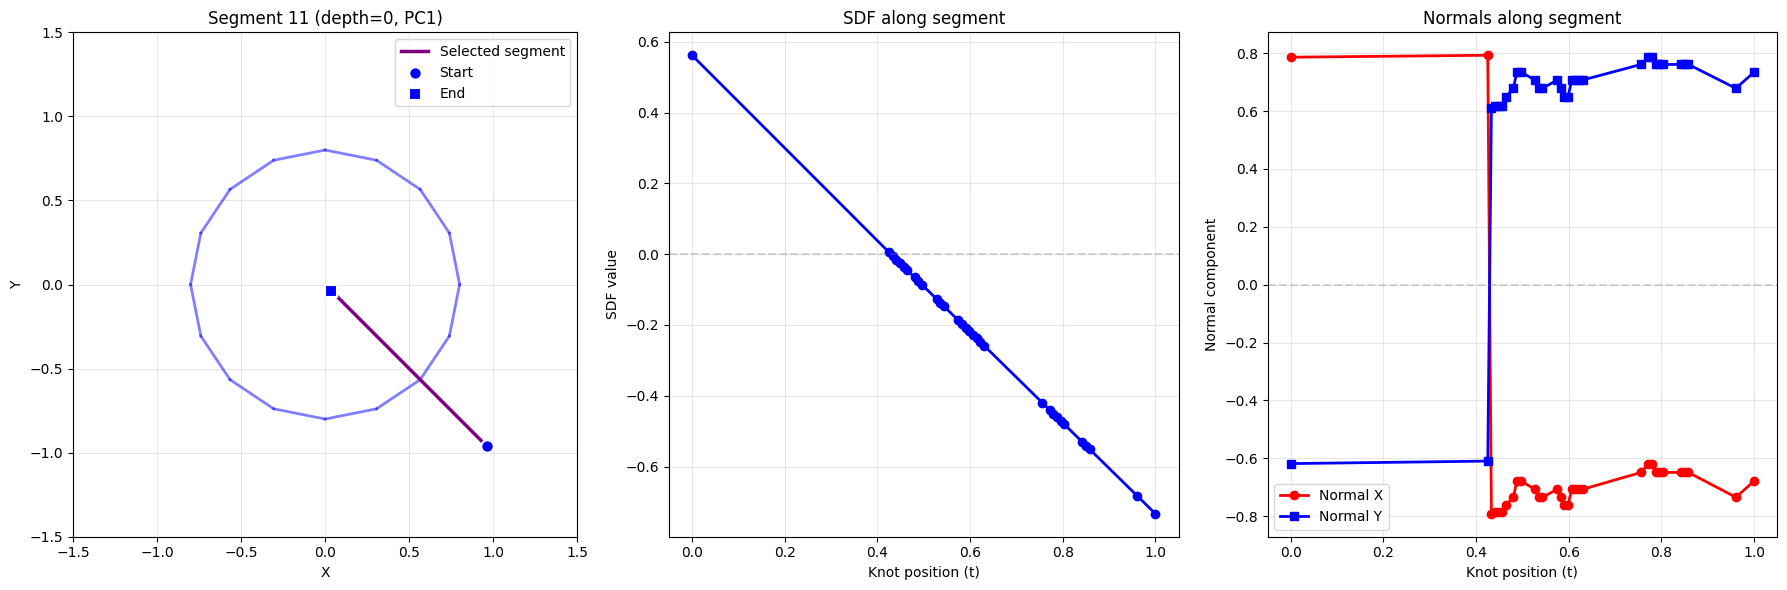

In [31]:
# Example: Analyze segment 0
for i in range(len(start_points_sub)):
    plot_segment_analysis(i)

In [ ]:
# Example: Analyze segment 5
plot_segment_analysis(5)